### 1.0 packages loading

In [3]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix,precision_recall_curve, auc
from sklearn.feature_selection import f_classif 
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin 
from scipy.stats import chi2_contingency

In [4]:
import os 
import sys 
import glob 
from tqdm import tqdm 
from itertools import cycle 
from sklearn import model_selection 
from sklearn import preprocessing 
from sklearn import linear_model 
from sklearn import feature_selection 
from sklearn import feature_selection 
import xgboost as xgb 
import optbinning 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', None)

(CVXPY) Aug 21 12:49:15 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.7.2996). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Aug 21 12:49:15 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.7.2996). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')


### 1.1 data loading

In [5]:
tc_data = pd.read_csv("L:/01. 협업/02. KCB/03. KCB_가명결합_2023.07.27/20230818_결합 데이터 반출물/2023-결합결과-003-001.csv")

In [6]:
y_flag = pd.read_csv("L:/01. 협업/02. KCB/03. KCB_가명결합_2023.07.27/tc_data_y_flag.csv")

In [27]:
total = pd.merge(tc_data, y_flag, how='inner', on=['KEY', 'KCB_SCORE', 'agg_prob', 'agg_score', 'THINFILE1', 'THINFILE2', 'model_name', 'SP_SCORE'])

In [28]:
standard_column = "KCB_SCORE"
total = total[total[standard_column].notnull()]

### segmentation 구분

In [29]:
total['model_name'].replace({"inactive-v2.0.0":2}, inplace=True)

In [30]:
total['model_name'].replace({"active-v2.0.0":1}, inplace=True)

In [31]:
active = total[total['model_name']==1]

In [10]:
len(active.columns)

99

### y데이터와X를 위한 dataset 1차 분리 -> 후에 test split 함

In [32]:
y = active['y1']

In [33]:
total = active.iloc[:,1:61]

In [34]:
total.columns

Index(['call_compare_w_else_z_score_3m_group',
       'call_compare_w_itself_z_score_1m_group',
       'call_compare_w_itself_z_score_3m_group',
       'call_compare_w_itself_z_score_6m_group',
       'call_duration_compare_w_itself_kurt_score_1m_group',
       'call_duration_compare_w_itself_kurt_score_3m_group',
       'call_duration_compare_w_itself_kurt_score_6m_group',
       'call_duration_compare_w_itself_skew_score_1m_group',
       'call_duration_compare_w_itself_skew_score_3m_group',
       'call_duration_compare_w_itself_skew_score_6m_group',
       'call_duration_compare_w_itself_z_score_1m_group',
       'call_duration_compare_w_itself_z_score_3m_group',
       'call_duration_compare_w_itself_z_score_6m_group',
       'call_duration_non_contact_sum_in_1m_group',
       'call_duration_non_contact_sum_in_6m_group',
       'call_duration_non_contact_sum_out_1m_group',
       'call_duration_non_contact_sum_out_6m_group',
       'call_duration_total_sum_in_1m_non_working_hour_g

In [30]:
### null pct 0.95 이상 삭제

In [35]:
def check_col_null_rate(df: pd.DataFrame, max_null_pct: float, file_name = None) -> (pd.DataFrame, list):
    '''
        Calculate the null rate of each feature and return a list of feature which null rate not higher than max_null_pct.
    '''
    col_null_rate = df.isnull().mean().reset_index()
    col_null_rate = col_null_rate.rename(columns = {'index': 'feature', 0: 'null_pct'})
    col_null_rate['keep'] = (col_null_rate['null_pct'] <= max_null_pct)*1
    keep_cols_list = col_null_rate[col_null_rate['keep'] == 1]['feature'].tolist()
    if file_name:
        col_null_rate.to_csv(file_name)
    return col_null_rate, keep_cols_list

In [36]:
# Setting the upper limit for the missing value rate
max_null_pct = 0.95
df_col_null_rate, keep_cols = check_col_null_rate(df = total, 
                                            max_null_pct = max_null_pct, 
                                            file_name = None)

In [37]:
total = total[keep_cols]
total.shape

(12734, 60)

In [21]:
total.columns

Index(['call_compare_w_else_z_score_3m_group',
       'call_compare_w_itself_z_score_1m_group',
       'call_compare_w_itself_z_score_3m_group',
       'call_compare_w_itself_z_score_6m_group',
       'call_duration_compare_w_itself_kurt_score_1m_group',
       'call_duration_compare_w_itself_kurt_score_3m_group',
       'call_duration_compare_w_itself_kurt_score_6m_group',
       'call_duration_compare_w_itself_skew_score_1m_group',
       'call_duration_compare_w_itself_skew_score_3m_group',
       'call_duration_compare_w_itself_skew_score_6m_group',
       'call_duration_compare_w_itself_z_score_1m_group',
       'call_duration_compare_w_itself_z_score_3m_group',
       'call_duration_compare_w_itself_z_score_6m_group',
       'call_duration_non_contact_sum_in_1m_group',
       'call_duration_non_contact_sum_in_6m_group',
       'call_duration_non_contact_sum_out_1m_group',
       'call_duration_non_contact_sum_out_6m_group',
       'call_duration_total_sum_in_1m_non_working_hour_g

In [39]:
# 우불량 count 
y.value_counts()

0    12657
1       77
Name: y1, dtype: int64

In [40]:
total_cat = total.select_dtypes(include='object').copy() 
total_num = total.select_dtypes(include='number').copy()

In [42]:
total_cols = total.columns.tolist() 
total_cat_cols= total_cat.columns.tolist()

In [43]:
total.describe().T

,count,mean,std,min,25%,50%,75%,max
call_compare_w_else_z_score_3m_group,12734.0,5.807288,0.603342,1.0,6.0,6.0,6.0,6.0
call_compare_w_itself_z_score_1m_group,12733.0,2.707139,0.861566,1.0,2.0,3.0,3.0,4.0
call_compare_w_itself_z_score_3m_group,12734.0,3.824250,1.279169,1.0,3.0,4.0,4.0,6.0
call_compare_w_itself_z_score_6m_group,12734.0,5.850008,1.292327,2.0,5.0,6.0,6.0,10.0
call_duration_compare_w_itself_kurt_score_1m_group,12374.0,4.222563,2.034199,1.0,2.0,5.0,6.0,6.0
call_duration_compare_w_itself_kurt_score_3m_group,12685.0,2.744817,0.743890,1.0,2.0,3.0,3.0,4.0
call_duration_compare_w_itself_kurt_score_6m_group,12698.0,3.394865,1.217089,1.0,3.0,3.0,4.0,6.0
call_duration_compare_w_itself_skew_score_1m_group,12565.0,3.226423,1.176444,1.0,3.0,4.0,4.0,4.0
call_duration_compare_w_itself_skew_score_3m_group,12692.0,2.424598,1.126987,1.0,2.0,2.0,3.0,5.0
call_duration_compare_w_itself_skew_score_6m_group,12698.0,3.354544,0.898041,2.0,3.0,3.0,4.0,6.0


In [44]:
iv_score_dict = {}
for col in tqdm(total_cols): 
    if col in total_cat_cols:
        optb = optbinning.OptimalBinning(dtype='categorical', monotonic_trend ="auto_asc_desc")
        optb.fit(total[col], y)
    else:
        optb = optbinning.OptimalBinning(dtype='numerical', monotonic_trend="auto_asc_desc") 
        optb.fit(total[col], y) 
        binning_table = optb.binning_table 
        binning_table.build() 
        iv_score_dict[col] = binning_table.iv
        
iv_score_df = pd.Series(iv_score_dict) 
iv_score_df.sort_values(ascending=False, inplace=True)

100%|██████████| 60/60 [00:01<00:00, 52.32it/s]


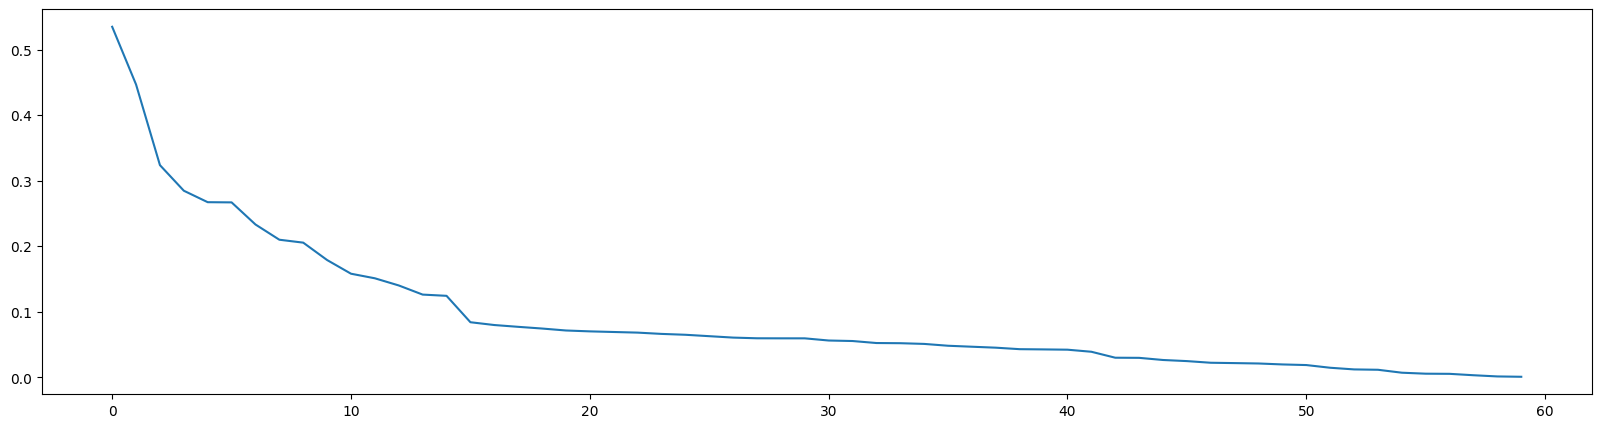

In [45]:
fig, ax = plt.subplots(figsize=(20,5)) 
iv_score_df.reset_index(drop=True).plot() 
plt.show()

In [46]:
iv_score_df.head(20)

call_zero_duration_count_in_6m_group                        0.534718
call_non_contact_count_in_6m_group                          0.446649
call_non_contact_count_in_1m_group                          0.323686
call_zero_duration_count_in_1m_group                        0.284654
call_total_distinct_caller_in_6m_non_working_hour_group     0.267161
call_zero_duration_distinct_caller_out_6m_group             0.266871
call_duration_non_contact_sum_out_6m_group                  0.233148
call_total_distinct_caller_1m_weekday_group                 0.209908
call_duration_non_contact_sum_in_6m_group                   0.205457
call_total_distinct_caller_out_6m_non_working_hour_group    0.178909
call_total_distinct_caller_in_6m_working_hour_group         0.158068
call_non_contact_distinct_caller_out_6m_group               0.151072
call_non_contact_count_out_6m_group                         0.140155
call_duration_compare_w_itself_kurt_score_3m_group          0.126223
call_total_count_in_6m_non_working

In [47]:
selected_features = iv_score_df[iv_score_df >= 0.1] 

In [50]:
len(selected_features)

15

In [49]:
# selecting features TOP 35 IV values 
selected_features = selected_features.index.values 
total_cat_cols = [ col for col in total_cat_cols if col in selected_features]
total_cols = [col for col in total_cols if col in selected_features]

----------------------------------------------------------------------------------------------------
############################## Featrue Name :  call_zero_duration_count_in_6m_group





,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 1.50)",9335,0.733077,9305,30,0.003214,0.63495,0.219411,0.026975
1,"[1.50, 3.50)",2465,0.193576,2436,29,0.011765,-0.671343,0.123635,0.015171
2,"[3.50, inf)",925,0.072640,907,18,0.019459,-1.18239,0.191673,0.022654
3,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
4,Missing,9,0.000707,9,0,0.000000,0.0,0.000000,0.000000
Totals,,12734,1.000000,12657,77,0.006047,,0.534718,0.064799


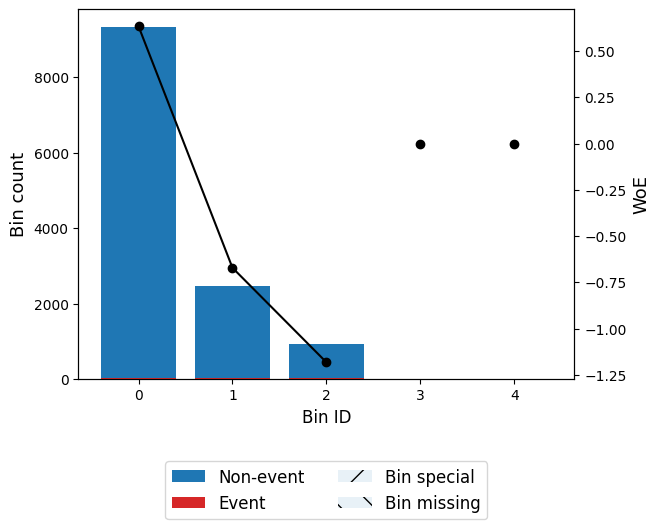

None

----------------------------------------------------------------------------------------------------
############################## Featrue Name :  call_non_contact_count_in_6m_group





,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 1.50)",10696,0.839956,10654,42,0.003927,0.433861,0.128550,0.015944
1,"[1.50, 3.50)",1115,0.087561,1097,18,0.016143,-0.992198,0.145947,0.017530
2,"[3.50, inf)",907,0.071227,890,17,0.018743,-1.144152,0.172152,0.020417
3,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
4,Missing,16,0.001256,16,0,0.000000,0.0,0.000000,0.000000
Totals,,12734,1.000000,12657,77,0.006047,,0.446649,0.053891


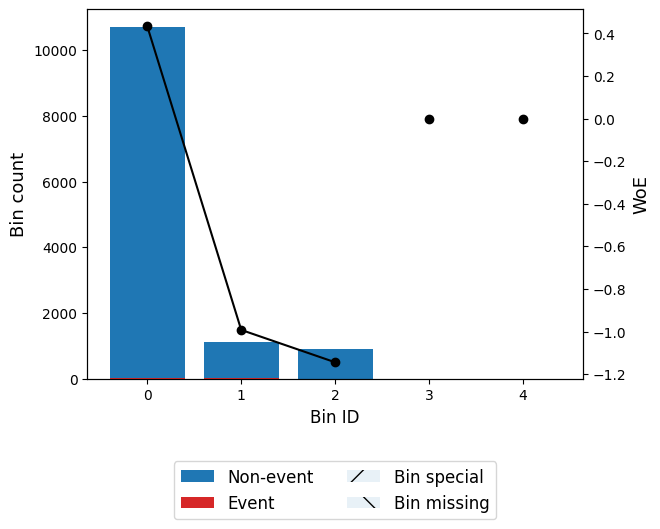

None

----------------------------------------------------------------------------------------------------
############################## Featrue Name :  call_non_contact_count_in_1m_group





,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 1.50)",9697,0.761505,9658,39,0.004022,0.40982,0.105144,0.013052
1,"[1.50, 2.50)",1573,0.123528,1558,15,0.009536,-0.459052,0.032919,0.004079
2,"[2.50, inf)",1332,0.104602,1310,22,0.016517,-1.01542,0.185024,0.022183
3,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
4,Missing,132,0.010366,131,1,0.007576,-0.226963,0.000599,0.000075
Totals,,12734,1.000000,12657,77,0.006047,,0.323686,0.039389


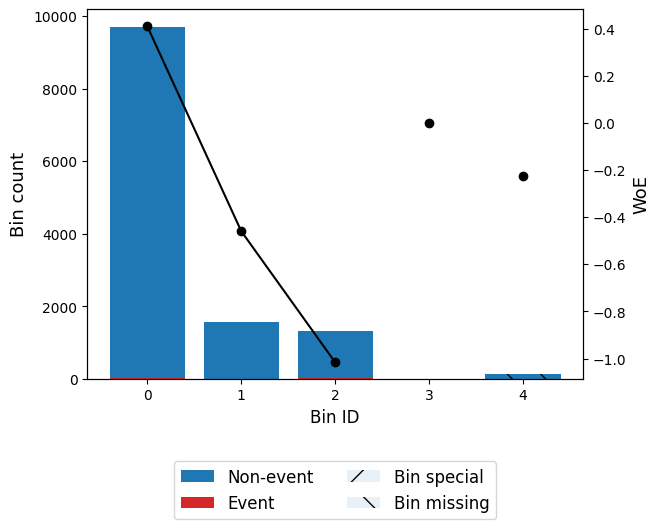

None

----------------------------------------------------------------------------------------------------
############################## Featrue Name :  call_zero_duration_count_in_1m_group





,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 1.50)",9298,0.730171,9260,38,0.004087,0.393713,0.093745,0.011643
1,"[1.50, 2.50)",940,0.073818,934,6,0.006383,-0.054443,0.000225,0.000028
2,"[2.50, 3.50)",840,0.065965,830,10,0.011905,-0.68332,0.043933,0.005387
3,"[3.50, 4.50)",728,0.057170,719,9,0.012363,-0.721523,0.043347,0.005304
4,"[4.50, inf)",827,0.064944,814,13,0.015719,-0.965149,0.100876,0.012142
5,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
6,Missing,101,0.007932,100,1,0.009901,-0.49699,0.002528,0.000313
Totals,,12734,1.000000,12657,77,0.006047,,0.284654,0.034817


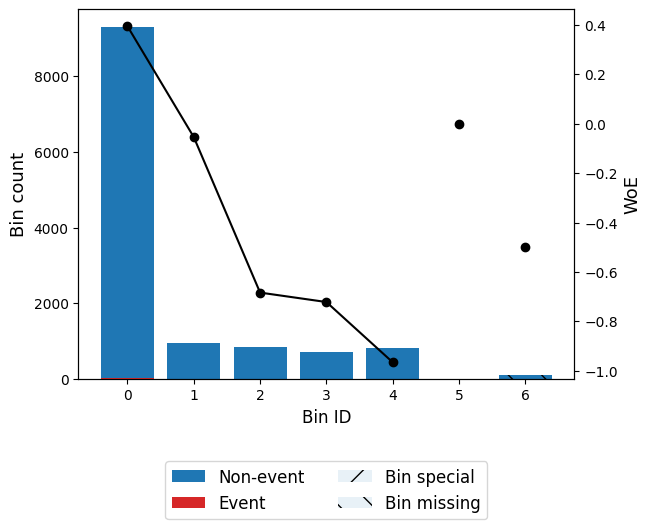

None

----------------------------------------------------------------------------------------------------
############################## Featrue Name :  call_total_distinct_caller_in_6m_non_working_hour_group





,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 1.50)",5917,0.464662,5898,19,0.003211,0.635769,0.139382,0.017135
1,"[1.50, 4.50)",5610,0.440553,5569,41,0.007308,-0.190762,0.017640,0.002202
2,"[4.50, inf)",1196,0.093922,1179,17,0.014214,-0.862952,0.110138,0.013355
3,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
4,Missing,11,0.000864,11,0,0.000000,0.0,0.000000,0.000000
Totals,,12734,1.000000,12657,77,0.006047,,0.267161,0.032692


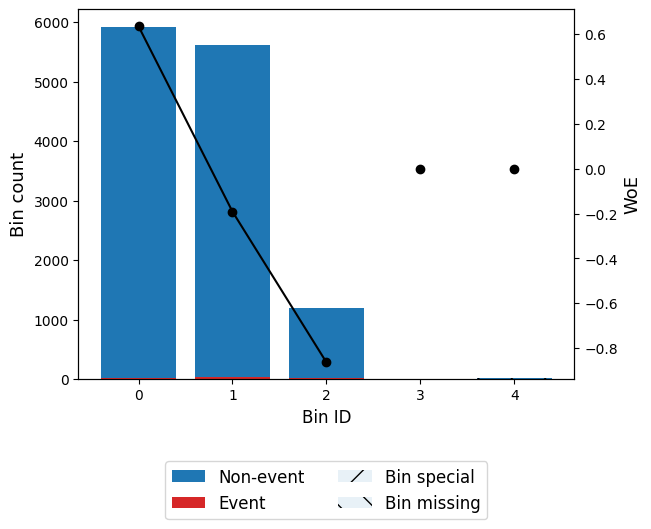

None

----------------------------------------------------------------------------------------------------
############################## Featrue Name :  call_zero_duration_distinct_caller_out_6m_group





,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 1.50)",1105,0.086776,1104,1,0.000905,1.904535,0.141388,0.015409
1,"[1.50, 4.50)",8365,0.656903,8323,42,0.005021,0.186948,0.020962,0.002616
2,"[4.50, inf)",3241,0.254515,3207,34,0.010491,-0.55543,0.104521,0.012900
3,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
4,Missing,23,0.001806,23,0,0.000000,0.0,0.000000,0.000000
Totals,,12734,1.000000,12657,77,0.006047,,0.266871,0.030925


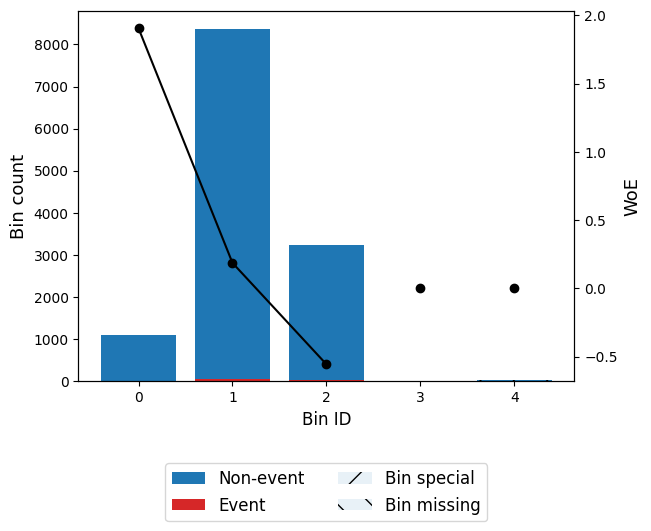

None

----------------------------------------------------------------------------------------------------
############################## Featrue Name :  call_duration_non_contact_sum_out_6m_group





,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 2.50)",4500,0.353385,4487,13,0.002889,0.74183,0.137740,0.016833
1,"[2.50, 4.50)",7020,0.551280,6970,50,0.007123,-0.164813,0.016262,0.002030
2,"[4.50, inf)",1054,0.082771,1040,14,0.013283,-0.794242,0.079146,0.009641
3,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
4,Missing,160,0.012565,160,0,0.000000,0.0,0.000000,0.000000
Totals,,12734,1.000000,12657,77,0.006047,,0.233148,0.028505


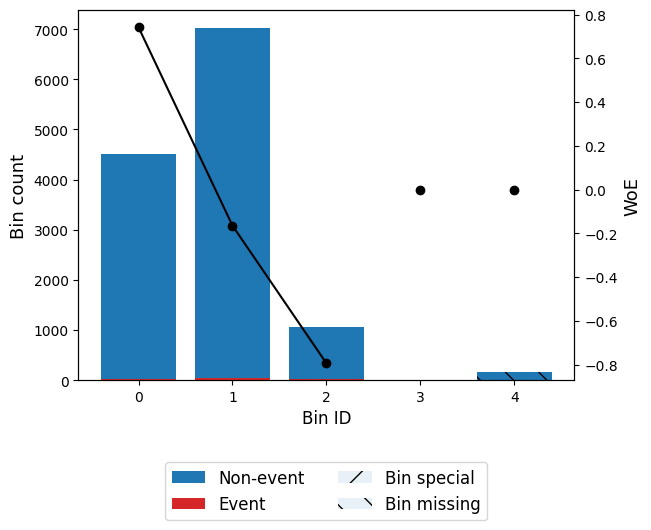

None

----------------------------------------------------------------------------------------------------
############################## Featrue Name :  call_total_distinct_caller_1m_weekday_group





,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 1.50)",4831,0.379378,4816,15,0.003105,0.669489,0.124321,0.015256
1,"[1.50, 3.50)",4578,0.359510,4549,29,0.006335,-0.046793,0.000806,0.000101
2,"[3.50, 4.50)",1778,0.139626,1761,17,0.009561,-0.461737,0.037699,0.004671
3,"[4.50, inf)",1546,0.121407,1530,16,0.010349,-0.541726,0.047082,0.005814
4,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
5,Missing,1,0.000079,1,0,0.000000,0.0,0.000000,0.000000
Totals,,12734,1.000000,12657,77,0.006047,,0.209908,0.025842


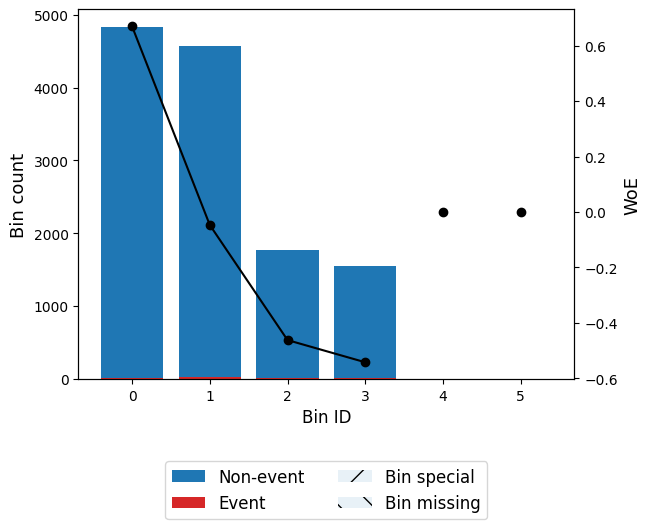

None

----------------------------------------------------------------------------------------------------
############################## Featrue Name :  call_duration_non_contact_sum_in_6m_group





,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 2.50)",4999,0.392571,4982,17,0.003401,0.578213,0.099937,0.012321
1,"[2.50, 3.50)",1649,0.129496,1642,7,0.004245,0.3556,0.013805,0.001717
2,"[3.50, 5.50)",5022,0.394377,4980,42,0.008363,-0.326645,0.049649,0.006179
3,"[5.50, inf)",974,0.076488,963,11,0.011294,-0.630002,0.042067,0.005173
4,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
5,Missing,90,0.007068,90,0,0.000000,0.0,0.000000,0.000000
Totals,,12734,1.000000,12657,77,0.006047,,0.205457,0.025389


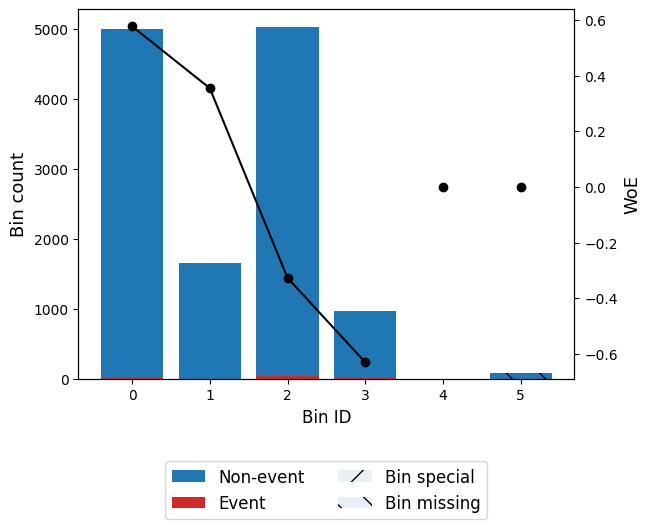

None

----------------------------------------------------------------------------------------------------
############################## Featrue Name :  call_total_distinct_caller_out_6m_non_working_hour_group





,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 2.50)",6330,0.497094,6304,26,0.004107,0.388683,0.062345,0.007744
1,"[2.50, 3.50)",1253,0.098398,1245,8,0.006385,-0.054711,0.000303,0.000038
2,"[3.50, 4.50)",2797,0.219648,2778,19,0.006793,-0.117113,0.003194,0.000399
3,"[4.50, 5.50)",1445,0.113476,1435,10,0.006920,-0.135825,0.002240,0.000280
4,"[5.50, inf)",880,0.069106,866,14,0.015909,-0.977333,0.110827,0.013327
5,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
6,Missing,29,0.002277,29,0,0.000000,0.0,0.000000,0.000000
Totals,,12734,1.000000,12657,77,0.006047,,0.178909,0.021788


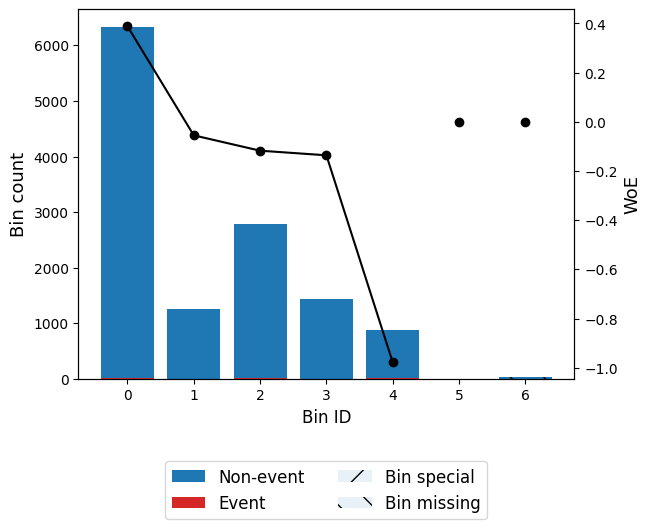

None

----------------------------------------------------------------------------------------------------
############################## Featrue Name :  call_total_distinct_caller_in_6m_working_hour_group





,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 2.50)",1873,0.147087,1870,3,0.001602,1.332921,0.145000,0.016892
1,"[2.50, inf)",10861,0.852913,10787,74,0.006813,-0.120128,0.013068,0.001633
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,12734,1.000000,12657,77,0.006047,,0.158068,0.018525


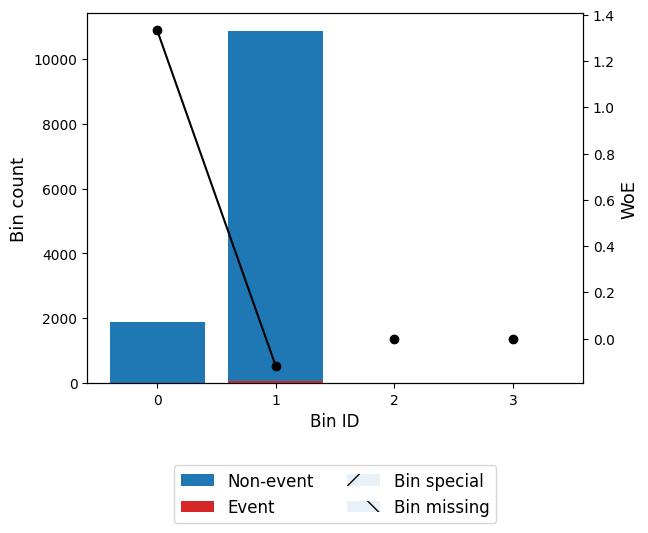

None

----------------------------------------------------------------------------------------------------
############################## Featrue Name :  call_non_contact_distinct_caller_out_6m_group





,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 2.50)",4680,0.367520,4662,18,0.003846,0.454668,0.061184,0.007583
1,"[2.50, 3.50)",1554,0.122035,1547,7,0.004505,0.296002,0.009270,0.001154
2,"[3.50, 4.50)",2028,0.159259,2014,14,0.006903,-0.13334,0.003026,0.000378
3,"[4.50, 5.50)",3203,0.251531,3180,23,0.007181,-0.173018,0.008211,0.001025
4,"[5.50, inf)",1234,0.096906,1219,15,0.012156,-0.704424,0.069382,0.008498
5,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
6,Missing,35,0.002749,35,0,0.000000,0.0,0.000000,0.000000
Totals,,12734,1.000000,12657,77,0.006047,,0.151072,0.018638


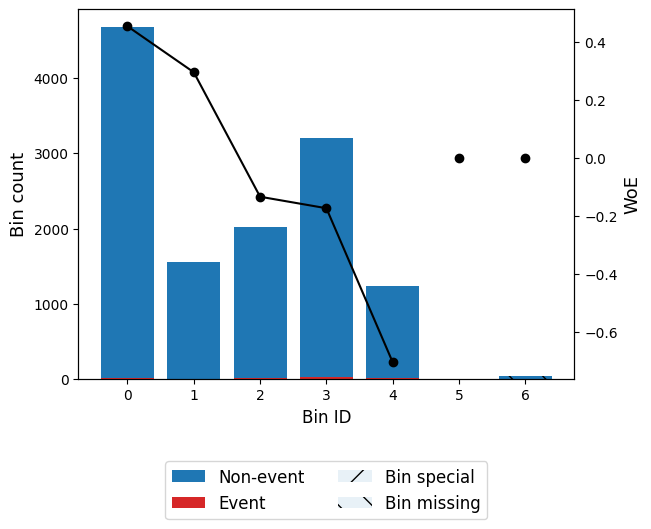

None

----------------------------------------------------------------------------------------------------
############################## Featrue Name :  call_non_contact_count_out_6m_group





,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 2.50)",3919,0.307759,3905,14,0.003572,0.528795,0.067002,0.008279
1,"[2.50, 3.50)",1571,0.123371,1564,7,0.004456,0.306931,0.010024,0.001248
2,"[3.50, 4.50)",1791,0.140647,1780,11,0.006142,-0.015687,0.000035,0.000004
3,"[4.50, 6.50)",4322,0.339406,4289,33,0.007635,-0.234859,0.021069,0.002628
4,"[6.50, inf)",1096,0.086069,1084,12,0.010949,-0.598654,0.042025,0.005176
5,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
6,Missing,35,0.002749,35,0,0.000000,0.0,0.000000,0.000000
Totals,,12734,1.000000,12657,77,0.006047,,0.140155,0.017335


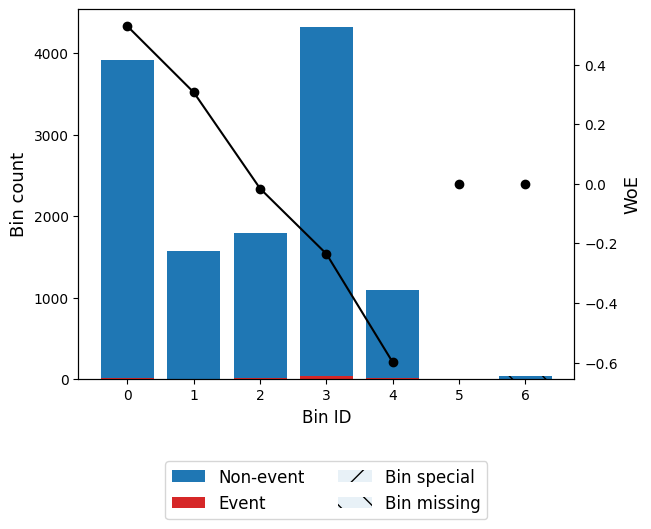

None

----------------------------------------------------------------------------------------------------
############################## Featrue Name :  call_duration_compare_w_itself_kurt_score_3m_group





,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 1.50)",865,0.067928,855,10,0.011561,-0.653644,0.040734,0.005003
1,"[1.50, 2.50)",2946,0.231349,2920,26,0.008826,-0.380918,0.040743,0.005062
2,"[2.50, inf)",8874,0.696875,8833,41,0.004620,0.270518,0.044746,0.005576
3,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
4,Missing,49,0.003848,49,0,0.000000,0.0,0.000000,0.000000
Totals,,12734,1.000000,12657,77,0.006047,,0.126223,0.015642


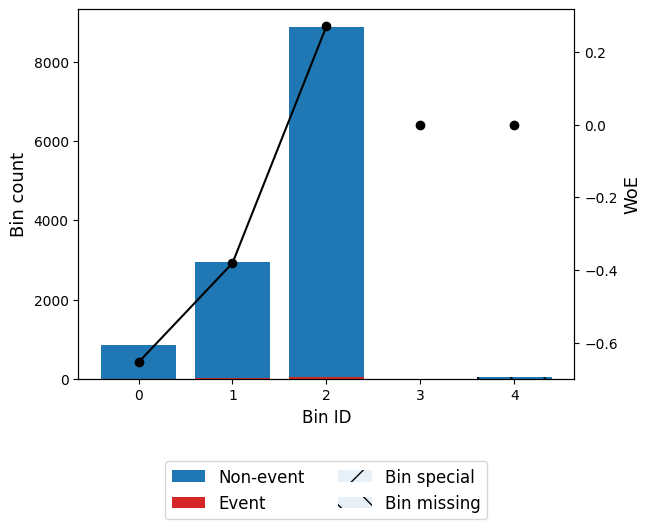

None

----------------------------------------------------------------------------------------------------
############################## Featrue Name :  call_total_count_in_6m_non_working_hour_group





,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 2.50)",1599,0.125569,1595,4,0.002502,0.886174,0.065638,0.007946
1,"[2.50, 4.50)",3643,0.286084,3626,17,0.004666,0.260512,0.017116,0.002134
2,"[4.50, 7.50)",6378,0.500864,6333,45,0.007056,-0.155293,0.013054,0.001630
3,"[7.50, inf)",1103,0.086619,1092,11,0.009973,-0.504289,0.028533,0.003529
4,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
5,Missing,11,0.000864,11,0,0.000000,0.0,0.000000,0.000000
Totals,,12734,1.000000,12657,77,0.006047,,0.124342,0.015239


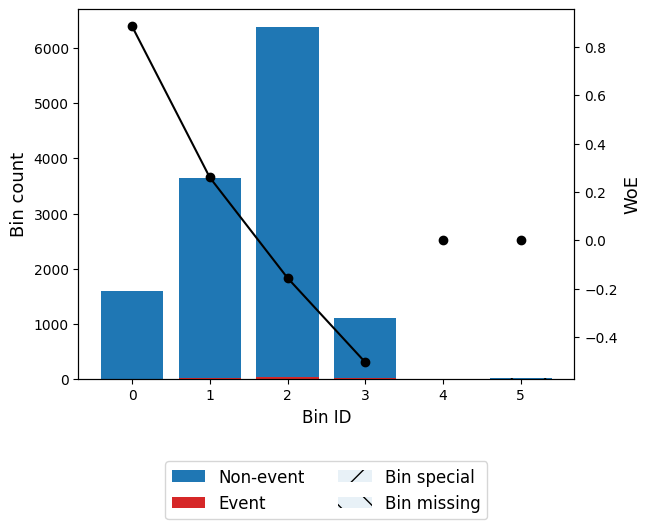

None

In [52]:
top_features = iv_score_df[:15].index.values
for col in top_features: 
    print("-"*100) 
    print("="*100) 
    print("############################## Featrue Name : ", col) 
    print("\n\n")
    
    if col in total_cat_cols:
        optb = optbinning.OptimalBinning(dtype='categorical', monotonic_trend = "auto_asc_desc")
        optb.fit(total[col], y)
    else:
        optb = optbinning.OptimalBinning(dtype='numerical',monotonic_trend = "auto_asc_desc")
        optb.fit(total[col], y)
        binning_table = optb.binning_table 
        
    display(binning_table.build()) 
    display(binning_table.plot(metric="woe"))

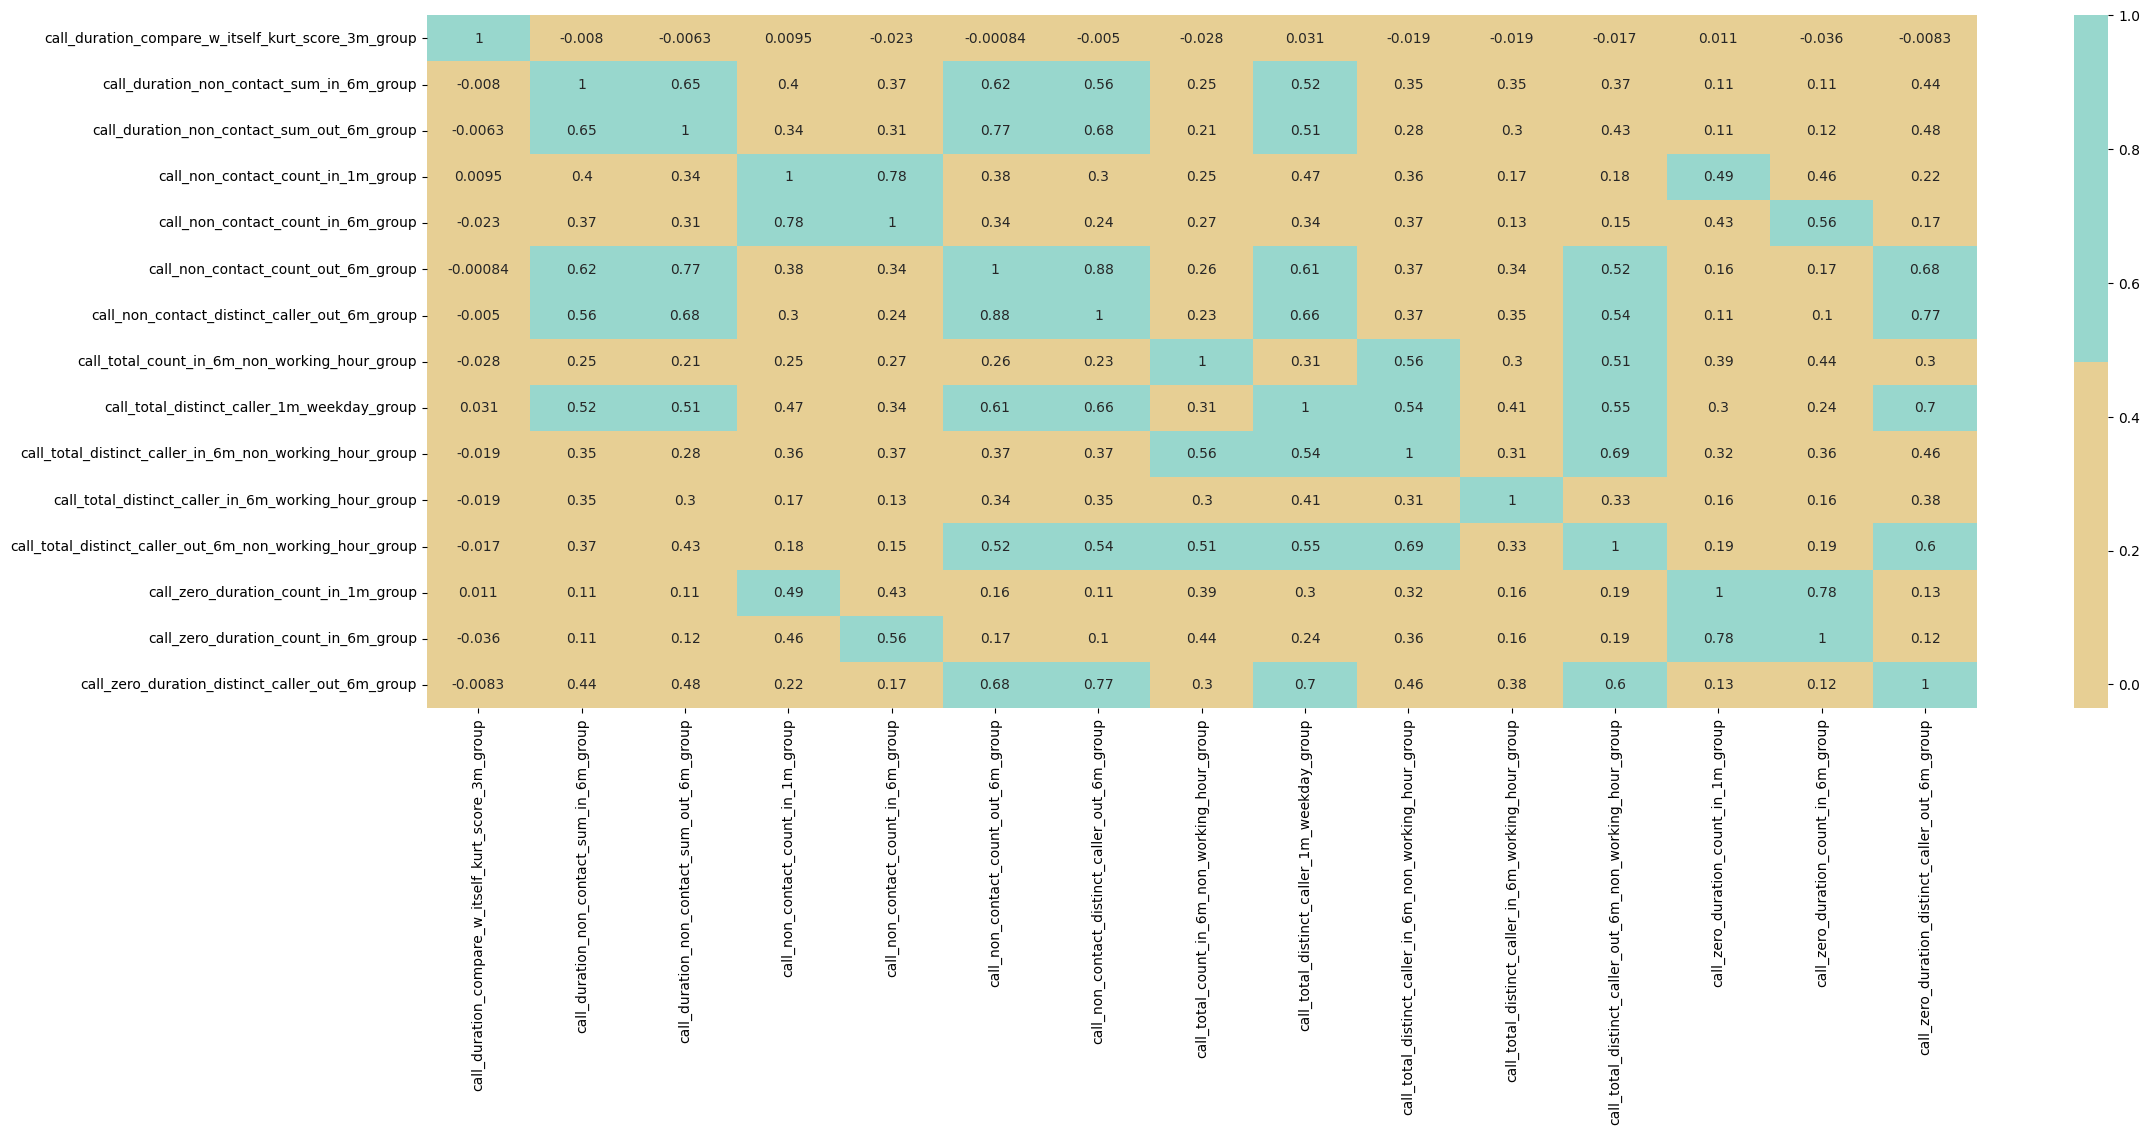

In [53]:
# Correlation Heatmap
corr_df = total[total_cols].corr() 
plt.figure(figsize=(25,9)) 
sns.heatmap(corr_df, annot=True, cmap=sns.color_palette("BrBG",2)); 
plt.show()

In [54]:
def drop_feature_selection(row, col, corr, row_iv, col_iv): 
    if row_iv >= col_iv :
        return col 
    else :
        return row

In [55]:
cor_matrix = total[total_cols].corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool_))
corr_df = upper_tri.stack().reset_index() 
corr_df.columns = ['row','col','corr'] 
corr_df=corr_df.drop_duplicates() 
corr_df = corr_df.sort_values('corr',ascending=False) 
corr_df = corr_df.query("corr >= 0.8") 
corr_df['row_iv'] = corr_df['row'].map(iv_score_dict) 
corr_df['col_iv'] = corr_df['col'].map(iv_score_dict)
corr_df['drop_feature'] = corr_df.apply(lambda x:
    drop_feature_selection(x['row'],x['col'], x['corr'],x['row_iv'],x['col_iv']), axis=1)

In [1]:
corr_df

NameError: name 'corr_df' is not defined

In [57]:
corr_drop_features = corr_df['drop_feature'].unique().tolist()

### modeling 

In [58]:
X = total
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state = 42, stratify = y)

In [59]:
selected_features = [col for col in selected_features if col not in corr_drop_features]
sample_data_cat_cols = [col for col in total_cat_cols if col in selected_features]
sample_data_cols = [col for col in total_cols if col in selected_features]

binning_process = optbinning.BinningProcess( 
    variable_names=sample_data_cols, 
    categorical_variables=sample_data_cat_cols
)

estimator = linear_model.LogisticRegression(max_iter=1000,class_weight='balanced') #steopwise selection ￿

In [60]:
# Scorecard ￿￿ - pdo ￿￿
scorecard = optbinning.Scorecard( 
    binning_process=binning_process, 
    estimator = estimator, 
    scaling_method = 'pdo_odds', 
    scaling_method_params={"pdo":20, "odds":50, "scorecard_points":700})

In [61]:
scorecard.fit(X_train, y_train)

Scorecard(binning_process=BinningProcess(categorical_variables=[],
                                         variable_names=['call_duration_compare_w_itself_kurt_score_3m_group',
                                                         'call_duration_non_contact_sum_in_6m_group',
                                                         'call_duration_non_contact_sum_out_6m_group',
                                                         'call_non_contact_count_in_1m_group',
                                                         'call_non_contact_count_in_6m_group',
                                                         'call_non_contact_distinct_caller_out_6m_group',
                                                         'cal...
                                                         'call_total_distinct_caller_in_6m_working_hour_group',
                                                         'call_total_distinct_caller_out_6m_non_working_hour_group',
                                                         'call_zero_duration_count_in_1m_group',
                                                         'call_zero_duration_count_in_6m_group',
                                                         'call_zero_duration_distinct_caller_out_6m_group']),
          estimator=LogisticRegression(class_weight='balanced', max_iter=1000),
          scaling_method='pdo_odds',
          scaling_method_params={'odds': 50, 'pdo': 20,
                                 'scorecard_points': 700})

In [62]:
scorecard_df = scorecard.table(style='detailed') 
scorecard_df

,Variable,Bin id,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Coefficient,Points
0,call_duration_compare_w_itself_kurt_score_3m_g...,0,"(-inf, 1.50)",688,0.067537,679,9,0.013081,-0.772232,0.060311,7.356962e-03,-1.463210,9.372475
1,call_duration_compare_w_itself_kurt_score_3m_g...,1,"[1.50, 2.50)",2371,0.232748,2352,19,0.008013,-0.277046,0.020544,2.559874e-03,-1.463210,30.278883
2,call_duration_compare_w_itself_kurt_score_3m_g...,2,"[2.50, 3.50)",5926,0.581722,5899,27,0.004556,0.291073,0.042827,5.334498e-03,-1.463210,54.264479
3,call_duration_compare_w_itself_kurt_score_3m_g...,3,"[3.50, inf)",1161,0.113969,1154,7,0.006029,0.009451,0.000010,1.266499e-06,-1.463210,42.374591
4,call_duration_compare_w_itself_kurt_score_3m_g...,4,Special,0,0.000000,0,0,0.000000,0.000000,0.000000,0.000000e+00,-1.463210,41.975585
5,call_duration_compare_w_itself_kurt_score_3m_g...,5,Missing,41,0.004025,41,0,0.000000,0.000000,0.000000,0.000000e+00,-1.463210,41.975585
0,call_duration_non_contact_sum_in_6m_group,0,"(-inf, 1.50)",3341,0.327967,3329,12,0.003592,0.529892,0.071664,8.854588e-03,-0.672181,52.252859
1,call_duration_non_contact_sum_in_6m_group,1,"[1.50, 2.50)",652,0.064003,651,1,0.001534,1.382881,0.066610,7.720342e-03,-0.672181,68.796608
2,call_duration_non_contact_sum_in_6m_group,2,"[2.50, 3.50)",1340,0.131540,1335,5,0.003731,0.491620,0.025174,3.115469e-03,-0.672181,51.510573
3,call_duration_non_contact_sum_in_6m_group,3,"[3.50, 5.50)",3992,0.391872,3958,34,0.008517,-0.338495,0.053304,6.631369e-03,-0.672181,35.410466


In [63]:
X_test['predict_proba'] = scorecard.predict_proba(X_test)[:,1]

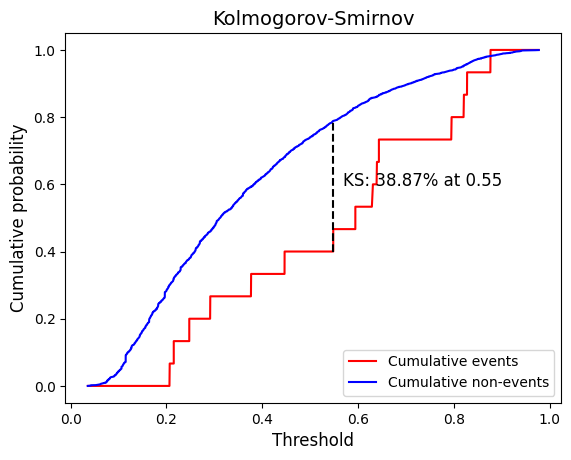

In [64]:
optbinning.scorecard.plot_ks(y_test, X_test['predict_proba'])

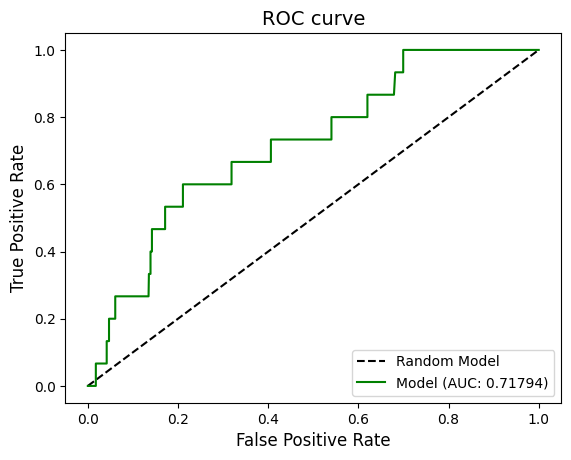

In [65]:
optbinning.scorecard.plot_auc_roc(y_test, X_test['predict_proba'])

In [66]:
score_train = scorecard.score(X_train) 
score_test = scorecard.score(X_test)
X_train['score'] = score_train 
X_test['score'] = score_test
mask = y_test == 0

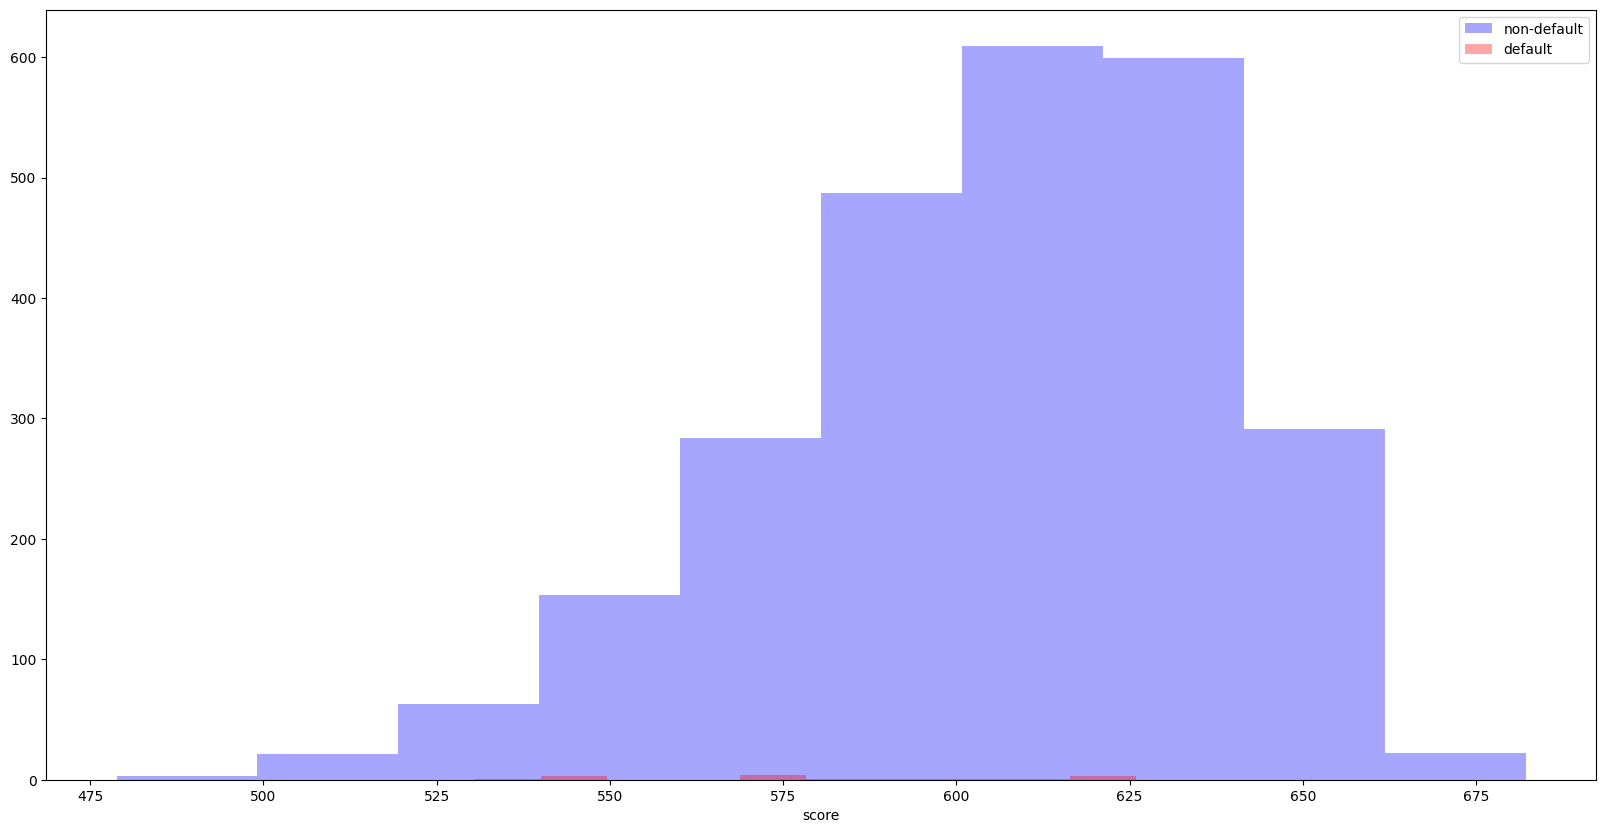

In [67]:
fig, ax = plt.subplots(figsize=(20,10))
plt.hist(score_test[mask], label = "non-default", color = "b", alpha = 0.35) 
plt.hist(score_test[~mask], label = "default", color="r", alpha=0.35) 
plt.xlabel("score") 
plt.legend() 
plt.show()

### KCB SCORE 분포

In [13]:
X_train, X_test, y_train, y_test = train_test_split(y_flag["KCB_SCORE"],y_flag['y1'], test_size=0.2,random_state = 42, stratify = y_flag['y1'])

In [17]:
mask = y_test == 0

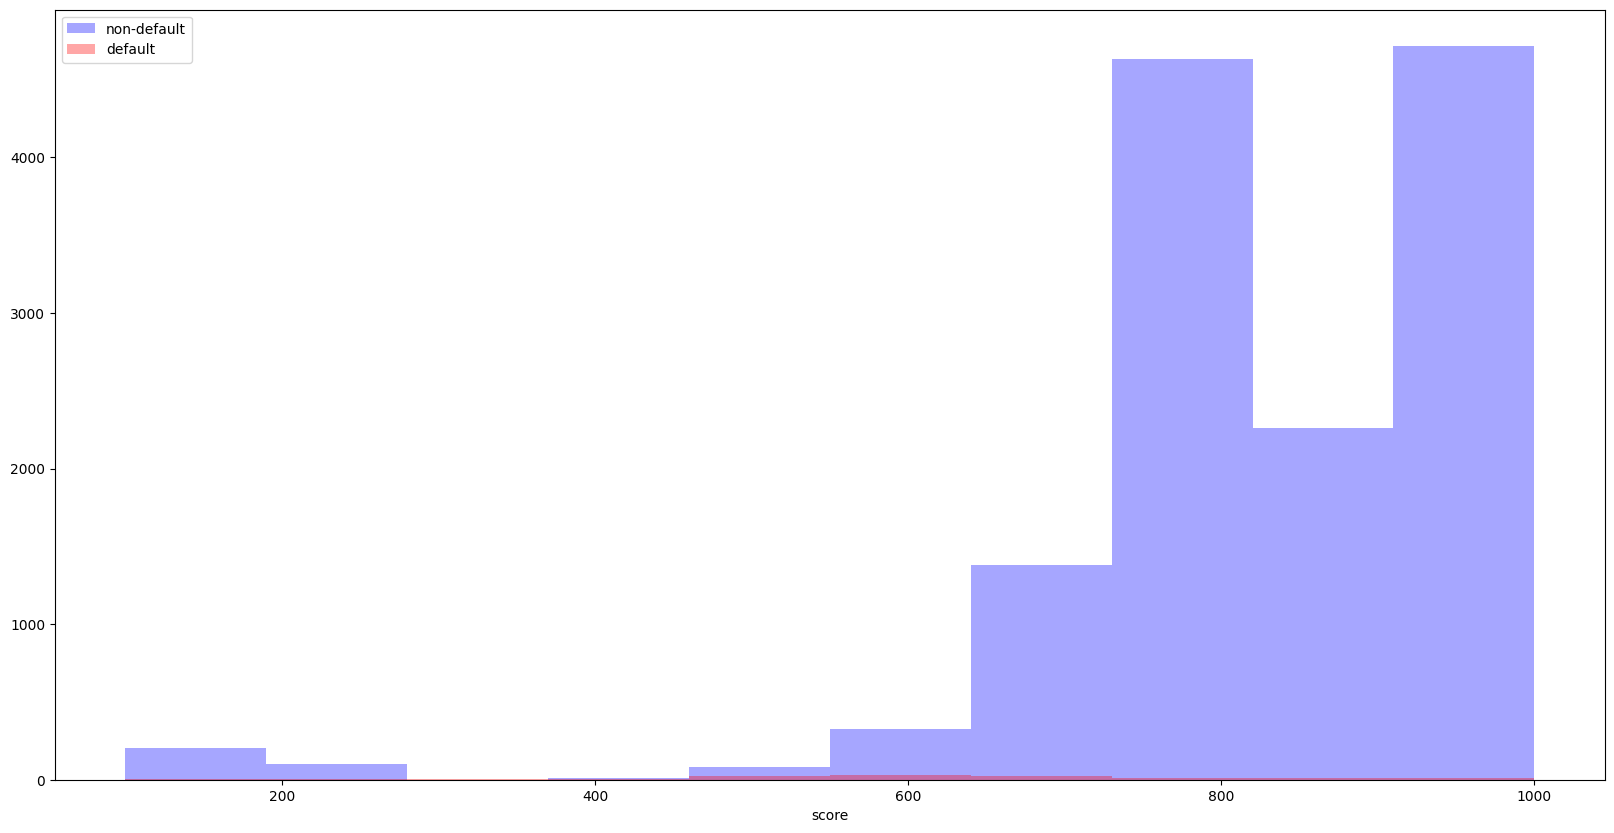

In [18]:
fig, ax = plt.subplots(figsize=(20,10))
plt.hist(X_test[mask], label = "non-default", color = "b", alpha = 0.35) 
plt.hist(X_test[~mask], label = "default", color="r", alpha=0.35) 
plt.xlabel("score") 
plt.legend() 
plt.show()